## Необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

import random

from torch.utils.data import DataLoader
import os

Очищаем память:

In [ ]:
import gc

def free_memory():
 gc.collect()
 torch.cuda.empty_cache()

free_memory()

## Загрузка датасета с Kaggle

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ninadaithal/imagesoasis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imagesoasis


## Предобработка данных

In [ ]:
# 4 класса
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

print(len(non_demented), "Non Demented samples")
print(len(very_mild_demented), "Very mild Dementia samples")
print(len(mild_demented), "Mild Dementia samples")
print(len(moderate_demented), "Moderate Dementia samples")

67222 Non Demented samples
13725 Very mild Dementia samples
5002 Mild Dementia samples
488 Moderate Dementia samples


Наблюдаем сильный дисбаланс классов:

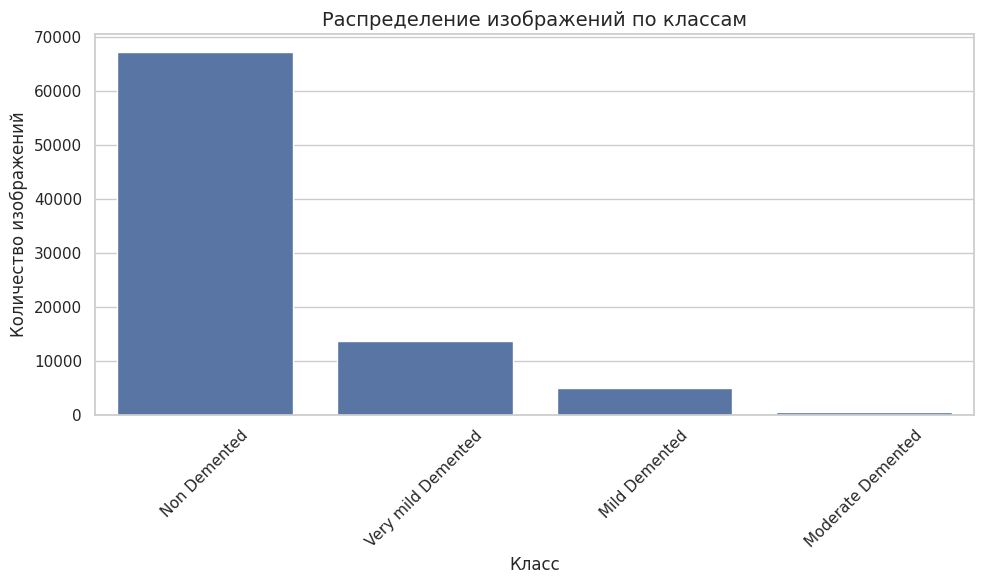

In [ ]:
# Исходные данные
classes = ['Non Demented', 'Very mild Demented', 'Mild Demented', 'Moderate Demented']
counts = [67222, 13725, 5002, 488]

# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Построение графика
ax = sns.barplot(x=classes, y=counts)
plt.title("Распределение изображений по классам", fontsize=14)
plt.xlabel("Класс", fontsize=12)
plt.ylabel("Количество изображений", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Визуализация случайного изображения:

In [ ]:
from PIL import Image

Original image size: (496, 248)


(np.float64(-0.5), np.float64(495.5), np.float64(247.5), np.float64(-0.5))

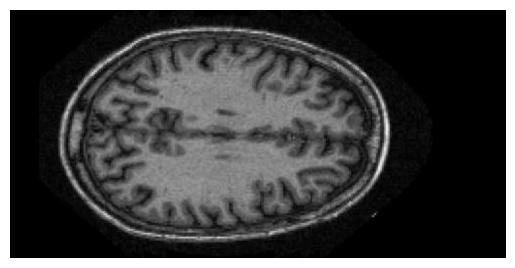

In [ ]:
sample_img = Image.open(random.choice(non_demented))

print(f"Original image size: {sample_img.size}")  # (width, height) - исходный размер рандомного изображения
plt.imshow(sample_img)
plt.axis('off')

Отделяем тестовую часть:

In [ ]:
from sklearn.model_selection import train_test_split

random.seed(42)

non_train, non_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

mild_train, mild_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

very_mild_train, very_mild_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

moderate_train, moderate_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42
)

Боремся с дисбалансом с помощью увеличения/уменьшения выборки (under-/oversampling)

In [ ]:
print(len(non_train), "Non Demented train samples")
print(len(very_mild_train), "Very mild Dementia train samples")
print(len(mild_train), "Mild Dementia train samples")
print(len(moderate_train), "Moderate Dementia train samples")

53777 Non Demented train samples
10980 Very mild Dementia train samples
4001 Mild Dementia train samples
390 Moderate Dementia train samples


In [ ]:
target_samples = 5000 # целевое количество примеров для каждого класса

# undersample
non_train_samp = random.sample(non_train, k=target_samples)
very_mild_train_samp = random.sample(very_mild_train, k=target_samples)

# oversample
mild_train_samp = random.choices(mild_train, k=target_samples)
moderate_train_samp = random.choices(moderate_train, k=target_samples)

In [ ]:
# проверяем:
print(len(non_train_samp))
print(len(very_mild_train_samp))
print(len(mild_train_samp))
print(len(moderate_train_samp))

5000
5000
5000
5000


То же самое для тестовой выборки:

In [ ]:
print(len(non_test), "Non Demented test samples")
print(len(very_mild_test), "Very mild Dementia test samples")
print(len(mild_test), "Mild Dementia test samples")
print(len(moderate_test), "Moderate Dementia test samples")

13445 Non Demented test samples
2745 Very mild Dementia test samples
1001 Mild Dementia test samples
98 Moderate Dementia test samples


?????Возможно, стоит убрать это и оставить тестовую выборку несбалансированной?????

In [ ]:
# target_samples = 640 # целевое количество примеров для каждого класса

# # undersample
# non_test_samp = random.sample(non_test, k=target_samples)
# very_mild_test_samp = random.sample(very_mild_test, k=target_samples)

# # oversample
# mild_test_samp = random.choices(mild_test, k=target_samples)
# moderate_test_samp = random.choices(moderate_test, k=target_samples)

Мне кажется нецелесообразным применять oversampling в тестовом множестве, поэтому просто уменьшила количество изображений для некоторых классов:

In [ ]:
target_samples = 1000 # целевое количество примеров

# undersample
non_test_samp = random.sample(non_test, k=target_samples)
very_mild_test_samp = random.sample(very_mild_test, k=target_samples)
mild_test_samp = random.choices(mild_test, k=target_samples)

moderate_test_samp = moderate_test

In [ ]:
# проверяем:
print(len(non_test_samp))
print(len(very_mild_test_samp))
print(len(mild_test_samp))
print(len(moderate_test_samp))

1000
1000
1000
98


In [ ]:
from torchvision import transforms

# трансформация (все изображения одного размера, но все равно добавим ресайз для уменьшения объема вычислений)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # преобразуем в тензор [C, H, W]
    transforms.Normalize((0.5,), (0.5,))
])


Загрузка и преобразование данных:

In [ ]:
from torch.utils.data import Dataset
class MRIDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # img = Image.open(self.file_paths[idx]).convert('RGB')
        img = Image.open(self.file_paths[idx]).convert('L')  # 'L' - режим grayscale
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# подготовка меток
train_labels = [0]*len(non_train_samp) + [1]*len(very_mild_train_samp) + \
               [2]*len(mild_train_samp) + [3]*len(moderate_train_samp)
test_labels = [0]*len(non_test_samp) + [1]*len(very_mild_test_samp) + \
              [2]*len(mild_test_samp) + [3]*len(moderate_test_samp)

# объединение путей
train_paths = non_train_samp + very_mild_train_samp + mild_train_samp + moderate_train_samp
test_paths = non_test_samp + very_mild_test_samp + mild_test_samp + moderate_test_samp

# создание датасета
train_dataset = MRIDataset(train_paths, train_labels, transform)
test_dataset = MRIDataset(test_paths, test_labels, transform)

????А еще возможно стоит отделить валидационную часть?????

In [ ]:
# еще раз проверяем баланс классов:
print("Train class distribution:", np.bincount(train_labels))
print("Test class distribution:", np.bincount(test_labels))

Train class distribution: [5000 5000 5000 5000]
Test class distribution: [1000 1000 1000   98]


In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [ ]:
# batch_images, batch_labels = next(iter(train_dataloader))

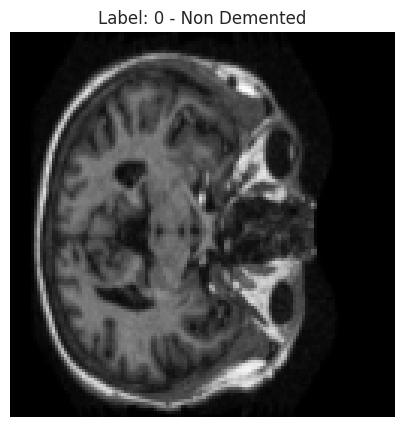

In [ ]:
# image = batch_images[0]
# label = batch_labels[0]

image, label = train_dataset[0]

# преобразуем тензор в формат [H, W, C] и numpy
# image = image.permute(1, 2, 0).numpy()

# визуализация
plt.figure(figsize=(5, 5))
plt.imshow(image.squeeze(), cmap='gray')  # squeeze() убирает канальную размерность
plt.title(f"Label: {label} - {classes[label]}")
plt.axis('off')
plt.show()

In [ ]:
sample, _ = train_dataset[0]
sample.shape

torch.Size([1, 128, 128])

## Несколько моделей

In [ ]:
activation = nn.ELU() # допускает отрицательные значения в отличие от ReLU

model1 = nn.Sequential(
    # изначально размерность 1 * 128 * 128
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # [32, 128, 128]
    activation, # добавляем нелинейность
    nn.MaxPool2d(2), # [32, 64, 64]

    nn.Conv2d(32, 64, kernel_size=3, padding=1), # [64, 64, 64]
    activation,
    nn.MaxPool2d(2), # [64, 32, 32]

    nn.Conv2d(64, 128, kernel_size=3, padding=1), # [128, 32, 32]
    activation,
    nn.MaxPool2d(2), # [128, 16, 16]

    # разворачиваем в вектор (преобразование 4D-тензора [batch, С, H, W] в 2D [batch, features])
    nn.Flatten(), # [batch, 256 * 16 * 16]

    # полносвязный слой
    nn.Linear(128 * 16 * 16, 512),
    activation,
    nn.Dropout(0.3), # регуляризация - случайное отключение 30% нейронов во время обучения

    nn.Linear(512, 4)  # здесь нет активации - CrossEntropyLoss включает softmax    ([batch, 2])
)

In [ ]:
model4 = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    activation,
    nn.Dropout2d(0.1),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    activation,
    nn.Dropout2d(0.1),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    activation,
    nn.MaxPool2d(2),

    nn.Flatten(),

    # полносвязный слой
    nn.Linear(128 * 16 * 16, 512),
    nn.BatchNorm1d(512),
    activation,
    nn.Dropout(0.3),

    nn.Linear(512, 4)
)

## Обучение моделей

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
criterion = nn.CrossEntropyLoss()

loaders = {"train": train_dataloader, "test": test_dataloader}

Визуализация:

In [ ]:
def plots(accuracy):
    """Функция для визуализации процесса обучения"""
    plt.figure(figsize=(12, 5))

    # график точности
    plt.plot(accuracy['train'], label='Train Accuracy')
    plt.plot(accuracy['test'], label='test Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# def evaluate_test_set(model, test_dataloader):
#     """Оценка модели на тестовой выборке"""
#     model.eval()
#     correct = 0
#     total = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = correct / total

#     return accuracy

In [ ]:
import matplotlib.pyplot as plt
from copy import deepcopy
import time

def train_model(model, patience=3):  # patience - сколько эпох терпеть ухудшение
    """Функция обучения модели с ранней остановкой"""
    start_time = time.time()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model = model.to(device)
    max_epochs = 15
    accuracy = {"train": [], "test": []}

    best_val_accuracy = 0.0
    best_epoch = 0
    best_model_weights = deepcopy(model.state_dict())  # сохраняем лучшие веса
    epochs_no_improve = 0  # счётчик эпох без улучшения

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device) # переносим данные на то же устройство
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                    loss = criterion(outp, y_batch)

                preds = outp.argmax(-1) # номер класса с наибольшей вероятностью
                correct = (preds == y_batch).sum()  # количество правильных ответов
                all = y_batch.size(0) # общее количество примеров в батче
                epoch_correct += correct.item()
                epoch_all += all

            epoch_accuracy = epoch_correct / epoch_all

            accuracy[k].append(epoch_accuracy)

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_accuracy:.4f}")

            if k == 'test':
                # проверяем, улучшилась ли точность на валидации
                if epoch_accuracy > best_val_accuracy:
                    best_val_accuracy = epoch_accuracy
                    best_epoch = epoch
                    best_model_weights = deepcopy(model.state_dict())
                    epochs_no_improve = 0  # сбрасываем счётчик
                else:
                    epochs_no_improve += 1

                # проверяем условие ранней остановки
                if epochs_no_improve >= patience:
                    print(f'\nEarly stopping triggered after epoch {epoch+1}')
                    print(f'Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}')

                    total_time = time.time() - start_time
                    # восстанавливаем лучшие веса модели
                    model.load_state_dict(best_model_weights)

                    # строим графики
                    plots(accuracy)
                    return {
                      'model': model,
                      'best_weights': best_model_weights,
                      'accuracy': accuracy,
                      'total_time': total_time
                  }

    # если дошли до конца эпох
    print(f'\nTraining completed. Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}')
    total_time = time.time() - start_time
    model.load_state_dict(best_model_weights)


    plots(accuracy)
    return {
      'model': model,
      'best_weights': best_model_weights,
      'accuracy': accuracy,
      'total_time': total_time
    }


Epoch: 1
Loader: train. Accuracy: 0.8086
Loader: test. Accuracy: 0.9322
Epoch: 2
Loader: train. Accuracy: 0.9586
Loader: test. Accuracy: 0.9661
Epoch: 3
Loader: train. Accuracy: 0.9787
Loader: test. Accuracy: 0.9832
Epoch: 4
Loader: train. Accuracy: 0.9861
Loader: test. Accuracy: 0.9693
Epoch: 5
Loader: train. Accuracy: 0.9646
Loader: test. Accuracy: 0.9852
Epoch: 6
Loader: train. Accuracy: 0.9958
Loader: test. Accuracy: 0.9926
Epoch: 7
Loader: train. Accuracy: 0.9953
Loader: test. Accuracy: 0.9903
Epoch: 8
Loader: train. Accuracy: 0.9901
Loader: test. Accuracy: 0.9839
Epoch: 9
Loader: train. Accuracy: 0.9853
Loader: test. Accuracy: 0.9932
Epoch: 10
Loader: train. Accuracy: 0.9946
Loader: test. Accuracy: 0.9900

Training completed. Best validation accuracy: 0.9932 at epoch 9


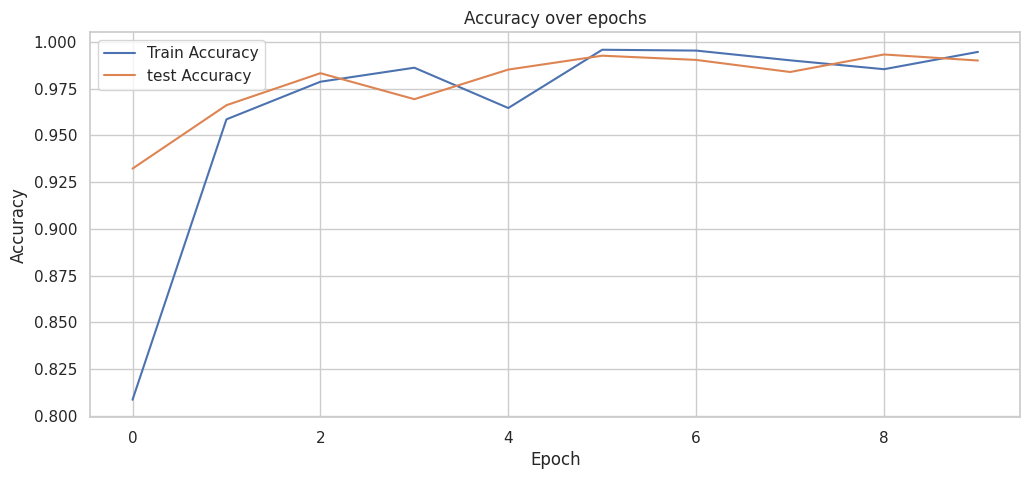

In [ ]:
results1 = train_model(model1)

In [ ]:
print(f"Model1 trained in {results1['total_time']:.2f} seconds")

Model1 trained in 488.75 seconds


Epoch: 1
Loader: train. Accuracy: 0.8478
Loader: test. Accuracy: 0.8961
Epoch: 2
Loader: train. Accuracy: 0.9552
Loader: test. Accuracy: 0.9387
Epoch: 3
Loader: train. Accuracy: 0.9792
Loader: test. Accuracy: 0.9793
Epoch: 4
Loader: train. Accuracy: 0.9833
Loader: test. Accuracy: 0.9787
Epoch: 5
Loader: train. Accuracy: 0.9896
Loader: test. Accuracy: 0.9861
Epoch: 6
Loader: train. Accuracy: 0.9888
Loader: test. Accuracy: 0.9781
Epoch: 7
Loader: train. Accuracy: 0.9905
Loader: test. Accuracy: 0.9835
Epoch: 8
Loader: train. Accuracy: 0.9928
Loader: test. Accuracy: 0.9874
Epoch: 9
Loader: train. Accuracy: 0.9922
Loader: test. Accuracy: 0.9906
Epoch: 10
Loader: train. Accuracy: 0.9919
Loader: test. Accuracy: 0.9864

Training completed. Best validation accuracy: 0.9906 at epoch 9


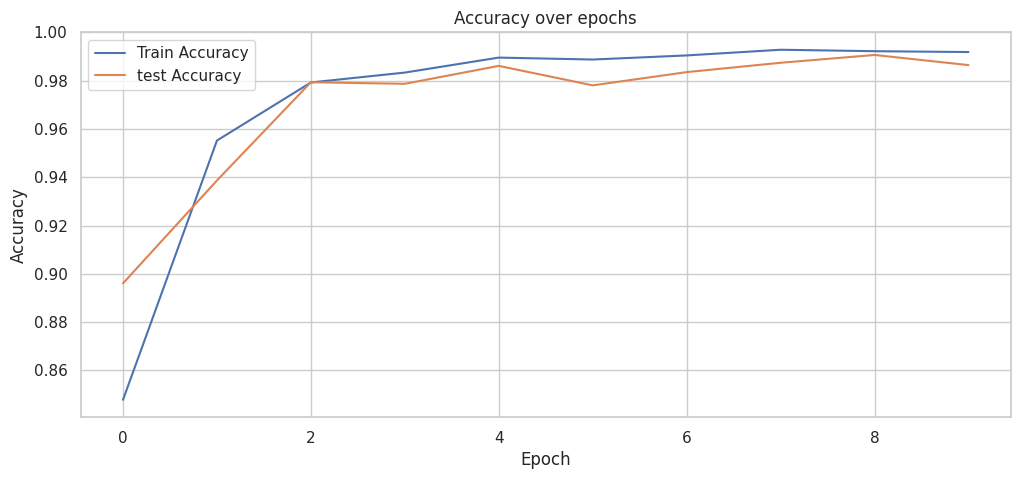

In [ ]:
results4 = train_model(model4)

In [ ]:
print(f"Model4 trained in {results4['total_time']:.2f} seconds")

Model4 trained in 425.75 seconds


Это с увеличенным количеством эпох: 15 вместо 10

Epoch: 1
Loader: train. Accuracy: 0.9900
Loader: test. Accuracy: 0.9884
Epoch: 2
Loader: train. Accuracy: 0.9944
Loader: test. Accuracy: 0.9910
Epoch: 3
Loader: train. Accuracy: 0.9937
Loader: test. Accuracy: 0.9903
Epoch: 4
Loader: train. Accuracy: 0.9950
Loader: test. Accuracy: 0.9958
Epoch: 5
Loader: train. Accuracy: 0.9936
Loader: test. Accuracy: 0.9929
Epoch: 6
Loader: train. Accuracy: 0.9952
Loader: test. Accuracy: 0.9874
Epoch: 7
Loader: train. Accuracy: 0.9961
Loader: test. Accuracy: 0.9897

Early stopping triggered after epoch 7
Best validation accuracy: 0.9958 at epoch 4


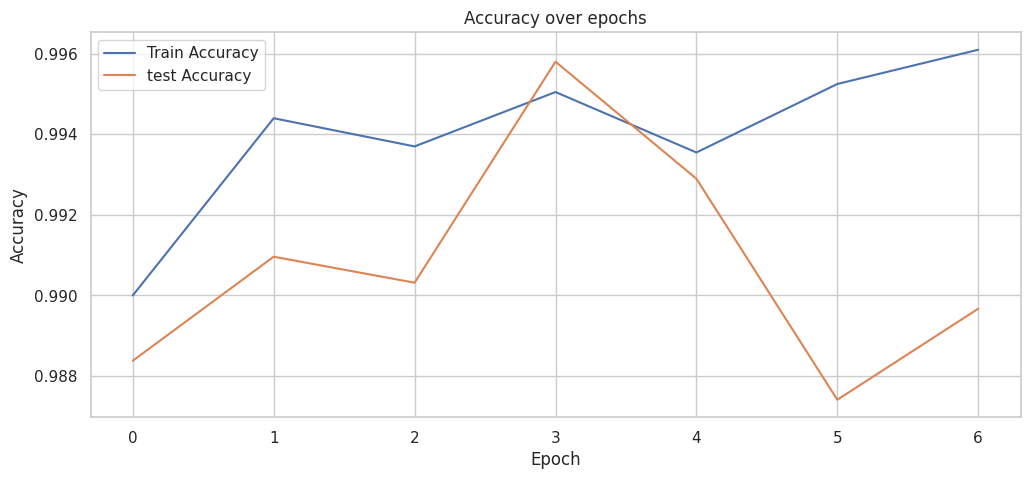

In [ ]:
results4 = train_model(model4)

## Визуализация неправильно классифицированных изображений

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_with_examples(model, test_dataset, test_dataloader, num_examples=7):
    """Визуализиация неправильно классифицированных изображений"""
    # num_samples - количество примеров для отображения (по умолчанию 7)

    model.eval()  # режим оценки
    all_preds = []
    all_labels = []
    class_names = ['Non Demented', 'Very mild Demented', 'Mild Demented', 'Moderate Demented']

    with torch.no_grad():  # отключаем вычисление градиентов для ускорения
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # создаем confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # находим индексы ошибочных примеров
    errors = np.where(np.array(all_labels) != np.array(all_preds))[0]

    # визуализируем примеры ошибок
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(errors[:num_examples]):
        img, true_label = test_dataset[idx]
        pred_label = all_preds[idx]

        plt.subplot(1, num_examples, i+1)
        img = img.permute(1, 2, 0).cpu()
        plt.imshow(img[:, :, 0], cmap='gray')
        # plt.imshow(img.permute(1, 2, 0).cpu()) # преобразуем тензор [C,H,W] в [H,W,C] для отображения
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')

    plt.show()

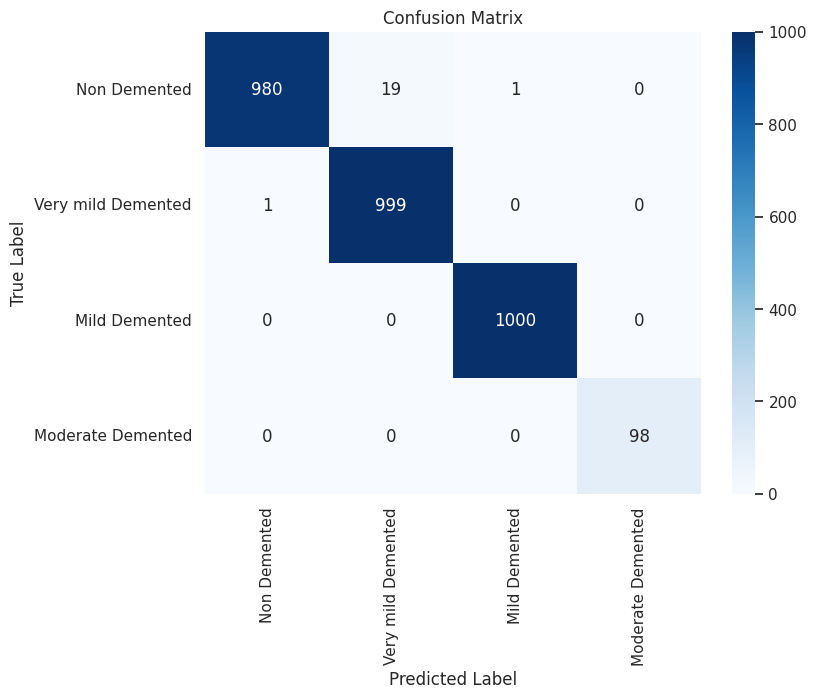

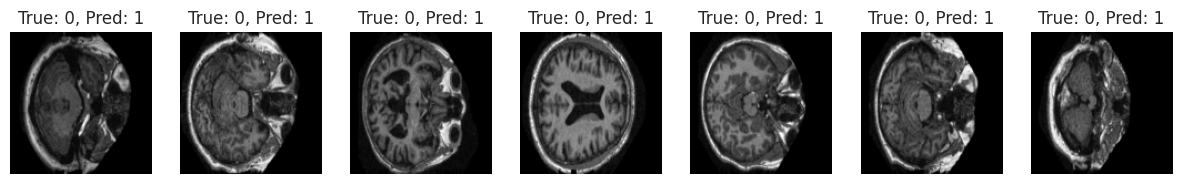

In [ ]:
plot_confusion_matrix_with_examples(model1, test_dataset, test_dataloader)

## Визуализация:

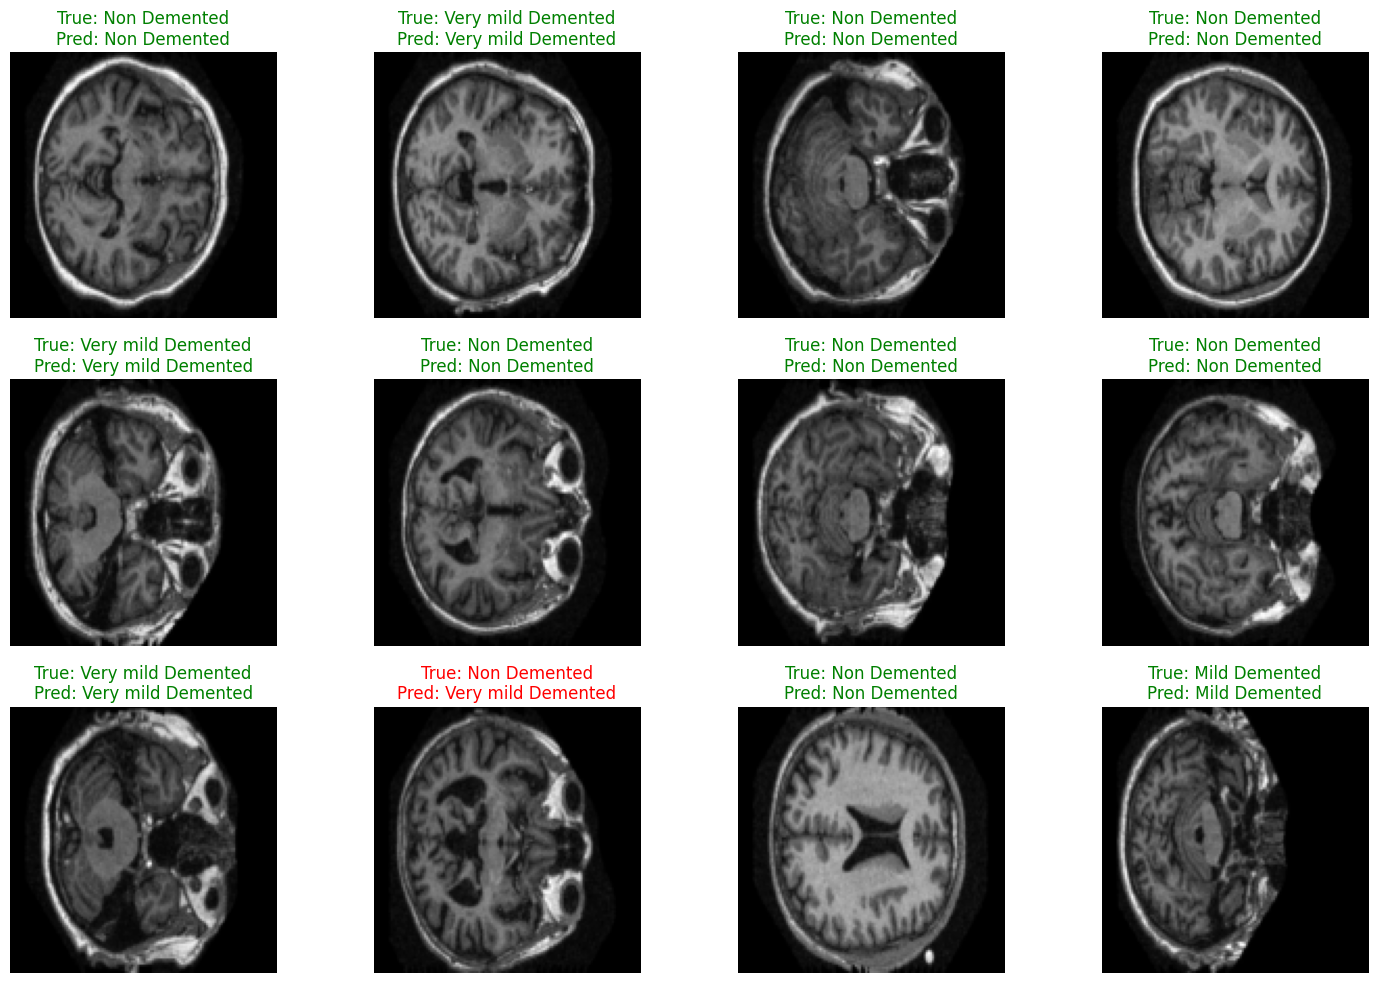

In [ ]:
from sklearn.metrics import confusion_matrix

def visualize_predictions(model, test_dataset, num_images=12):
    """Визуализация предсказаний модели на случайных тестовых изображениях"""
    model.eval()
    plt.figure(figsize=(15, 10))

    # выбираем случайные индексы
    indices = np.random.choice(len(test_dataset), num_images, replace=False) # replace=False означает, что индексы не будут повторяться

    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]
        # добавляем размерность батча (преобразуем [C, H, W] в [1, C, H, W])
        image = image.unsqueeze(0).to(device)


        with torch.no_grad():
            output = model(image)
            pred_label = output.argmax().item()

        # убираем размерность батча и переносим изображение обратно на CPU для визуализации
        image = image.squeeze().cpu()

        plt.subplot(3, 4, i+1)
        plt.imshow(image.squeeze().cpu(), cmap='gray')

        # зеленый цвет для правильных предсказаний, красный - для неправильных
        color = 'green' if pred_label == true_label else 'red'
        title = f'True: {classes[true_label]}\nPred: {classes[pred_label]}'
        plt.title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# визуализация случайных предсказаний
visualize_predictions(results1['model'], test_dataset)

То же самое что и выше, но без визулизации ошибочных примеров:

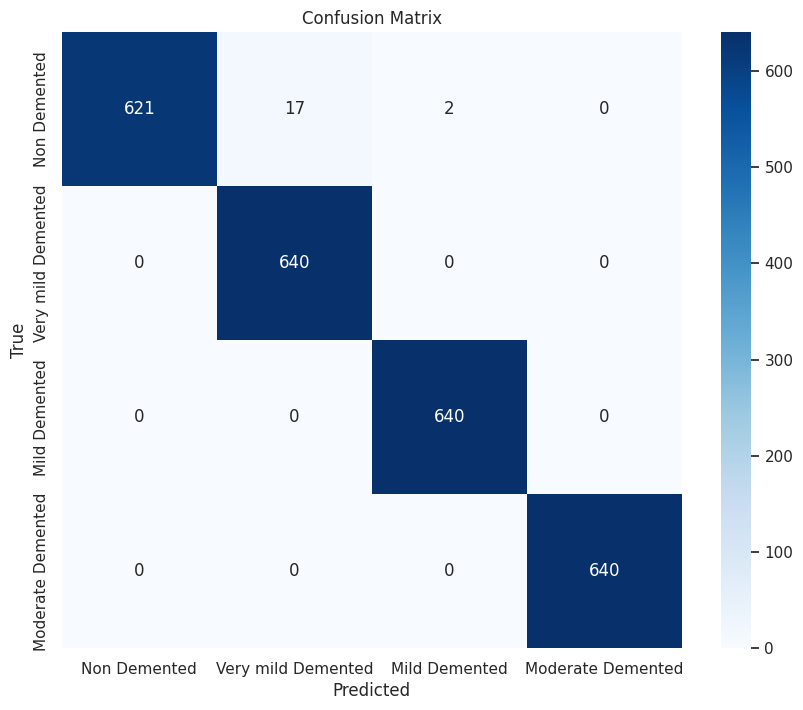

In [ ]:
def plot_confusion_matrix(model, test_loader):
    """Построение матрицы ошибок"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# матрица ошибок
plot_confusion_matrix(results1['model'], test_dataloader)

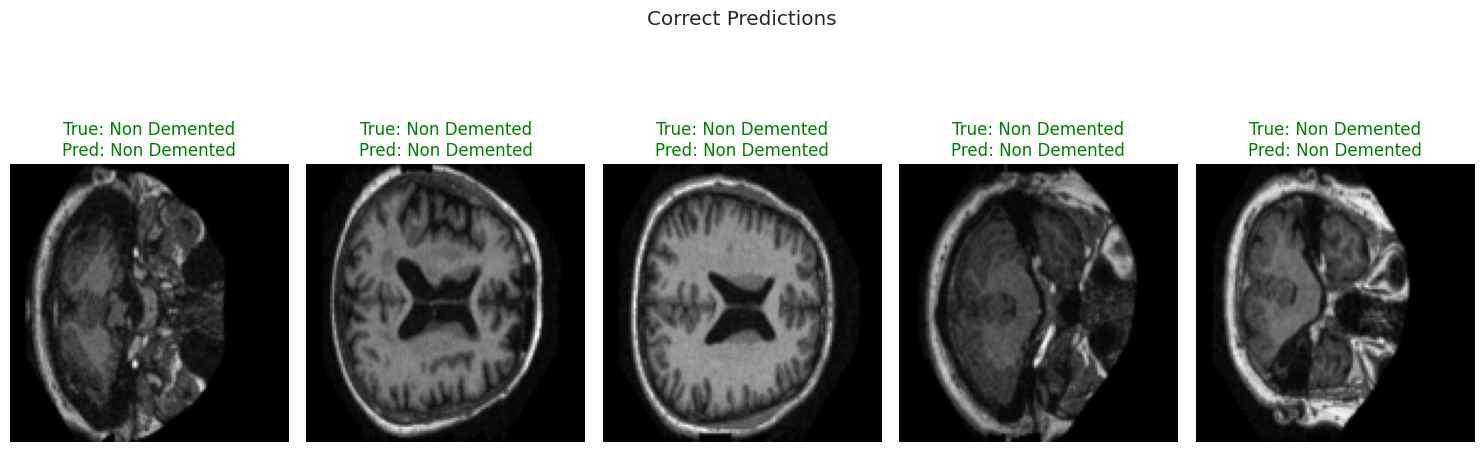

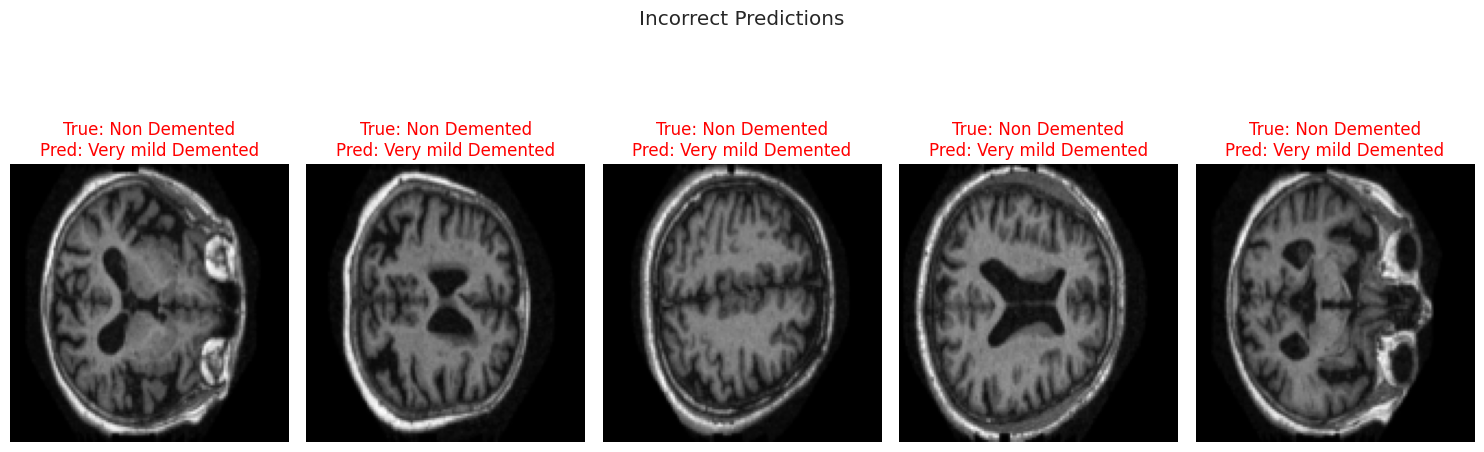

In [ ]:
def visualize_correct_incorrect(model, test_dataset, num_examples=5):
    """Визуализация примеров правильных и неправильных предсказаний"""
    model.eval()

    # собираем данные
    correct = []
    incorrect = []

    for i in range(len(test_dataset)):
        image, true_label = test_dataset[i]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            pred_label = output.argmax().item()

        if pred_label == true_label and len(correct) < num_examples:
            correct.append((image, true_label, pred_label))
        elif pred_label != true_label and len(incorrect) < num_examples:
            incorrect.append((image, true_label, pred_label))

        if len(correct) == num_examples and len(incorrect) == num_examples:
            break

    # визуализация правильных предсказаний
    plt.figure(figsize=(15, 5))
    plt.suptitle('Correct Predictions', y=1.05)
    for i, (image, true_label, pred_label) in enumerate(correct):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}', color='green')
        plt.axis('off')
    plt.tight_layout()

    # визуализация неправильных предсказаний
    plt.figure(figsize=(15, 5))
    plt.suptitle('Incorrect Predictions', y=1.05)
    for i, (image, true_label, pred_label) in enumerate(incorrect):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}', color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# примеры правильных и неправильных предсказаний
visualize_correct_incorrect(results1['model'], test_dataset)